In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit.compiler import transpile
from qiskit import BasicAer

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from qiskit.quantum_info import Statevector
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.h(1)
qc.cx(0, 1)
sv=Statevector.from_instruction(qc)
print(sv)

Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
            dims=(2, 2))


In [112]:
range(len(qc.data) - 1, -1, -1)

range(2, -1, -1)

In [175]:
from qiskit.providers.aer.library import SaveStatevector

num_qubits = qc.num_qubits
for index in range(len(qc.data) - 1, -1, -1):
    _inst = SaveStatevector(num_qubits, label = 'psi_' + str(index))
    qc.data.insert(index, [_inst, qc.qubits, None])

In [95]:
from qiskit import Aer
from IPython.display import display

simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(qc).result()
for key, value in result.data().items():
    print(key, value)
    # display(value.draw('latex'))

# Tight-binding Model

**This notebook follows the example of a tight-binding model from parts of this year's IBM Quantum Spring Challenge 2022.**

<div>
<img src="figs/tight-binding.png" width="400"/>
</div>

- model to calculate electronic structure of solids
- electron move on lattice sites (atoms)
    - need energy $\epsilon_i$ to occupy site $i$
    - can tunnel to neighboring site at energy cost $J$
    
$$H_{\rm tb}/\hbar = \sum_i \epsilon_i Z_i + J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j)$$

- time evolution governed by the Schrödinger equation:

$$ i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle $$

- solution (time-independent $H$): 
$ |\psi(t)\rangle = e^{-i H t / \hbar} |\psi(0)\rangle $

### Hamiltonian and time evolution operator
First, we import Pauli operators $I,X,Y,Z$ from qiskit and define the tight-binding Hamiltonian for three lattice sites and a function that returns the time evolution operator $e^{iHt}$.

We will first look at the evolution for the case of $\epsilon_i \equiv \epsilon = 0$. In this case, the energy required for the electron to occupy a lattice site (nuclei) is equal for all sites and the electron can move freely through the lattice. This type of behavior is characteristic for a conducting material (see IBM Quantum Spring Challenge 2022).

In [86]:
from qiskit.opflow import I, X, Y, Z

def H_tightBinding(J=1, eps=np.zeros(3)):
    # Interactions (I = identity; X and Y = Paulis; ^ is a tensor product)
    # XX_term = (X^X^I) + (I^X^X)
    # YY_term = (Y^Y^I) + (I^Y^Y)

    # # Z_term = eps[0]*(Z^I^I) + eps[1]*(I^Z^I) + eps[2]*(I^I^Z)
    # Z_term =  
    # H = J*(XX_term + YY_term) + Z_term
    # H = 0.1*(Z^I^I^I) + 0.4*(Y^Z^X^X) + 0.2*(X^X^I^I)
    # H = (1/2)*(3*(I^I^I) - (Z^I^I) -(I^Z^I) - (I^I^Z))
    # H = 0.5*((X^Z^X)+(Y^Z^Y))
    H = 1*(Z^Z^I) + 1*(I^Z^Z) +  1*(Z^I^Z) + 1*(X^X^I) + 1*(I^X^X) + 1*(X^I^X) + 1*(Y^Y^I) + 1*(I^Y^Y) + 1*(Y^I^Y) + (Z^I^I) + (I^Z^I) + (I^I^Z)
    # H = 1*(Z^Z^I^I) + 1*(I^Z^Z^I) +  1*(I^I^Z^Z) + (Z^I^I^Z)+ 1*(X^X^I^I) + 1*(I^X^X^I) + 1*(I^I^X^X)+(X^I^I^X) + 1*(Y^Y^I^I) + 1*(I^Y^Y^I) + 1*(I^I^Y^Y)+(Y^I^I^Y) + (Z^I^I^I) + (I^Z^I^I) + (I^I^Z^I)+(I^I^I^Z)
    # H = 1*(Z^Z^I) + 1*(I^Z^Z) + 1*(Z^I^Z) + 1*(X^X^I) + 1*(I^X^X)  + 1*(Y^Y^I) + 1*(I^Y^Y) + 1*(Y^I^Y) + (Z^I^I) + (I^Z^I) + (I^I^Z)
    # H = X^Y^Z^I
    # H = (Z^Z) + (X^X) + (Y^Y) + (Z^I) + (I^Z)
    return H

def U_t(t, H):
    return (t * H).exp_i()

J = 1
eps = [0, 0, 0]

H_tb = H_tightBinding(J, eps)

In [79]:
def exps():
    return (1/2)*(3*(I^I^I) - (Z^I^I) -(I^Z^I) - (I^I^Z))

In [80]:
exps().to_matrix()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 3.+0.j]])

In [96]:
def ut(t):
    return (t * (Z^Z^I)).exp_i() @ (t * (I^Z^Z)).exp_i() @ (t * (Z^I^Z)).exp_i() @ (t * (X^X^I)).exp_i() @ (t * (I^X^X)).exp_i() @ (t * (X^I^X)).exp_i() @ (t * (Y^Y^I)).exp_i() @ (t * (I^Y^Y)).exp_i() @ (t * (Y^I^Y)).exp_i()  @ (t * (Z^I^I)).exp_i() @ (t * (I^Z^I)).exp_i() @ (t * (I^I^Z)).exp_i()
    # return (t * (Z^Z^I)).exp_i() @ (t * (I^Z^Z)).exp_i() @ (t * (Z^I^Z)).exp_i() @ (t * (X^X^I)).exp_i() @ (t * (I^X^X)).exp_i() @ (t * (X^I^X)).exp_i() @ (t * (Y^Y^I)).exp_i() @ (t * (I^Y^Y)).exp_i() @ (t * (Y^I^Y)).exp_i() @ (t * (Z^I^I)).exp_i() @ (t * (I^Z^I)).exp_i() @ (t * (I^I^Z)).exp_i()
def U(t):
    u = (t * (Z^Z^I)).exp_i() @ (t * (I^Z^Z)).exp_i()  @ (t * (X^X^I)).exp_i() @ (t * (I^X^X)).exp_i()   @ (t * (Z^I^I)).exp_i() @ (t * (I^Z^I)).exp_i() @ (t * (I^I^Z)).exp_i()
    # u = (t * (Z^Z^I)).exp_i() @ (t * (I^Z^Z)).exp_i() @ (t * (Z^I^Z)).exp_i() @ (t * (X^X^I)).exp_i() @ (t * (I^X^X)).exp_i() @ (t * (X^I^X)).exp_i() @ (t * (Y^Y^I)).exp_i() @ (t * (I^Y^Y)).exp_i() @ (t * (Y^I^Y)).exp_i() @ (t * (Z^I^I)).exp_i() @ (t * (I^Z^I)).exp_i() @ (t * (I^I^Z)).exp_i()
    U_til = np.zeros((8,8))
    E,v = np.linalg.eigh(ut(t).to_matrix())
    for i in range(len(E)):
        U_til[i,i] = E[i]
    return [u.to_matrix(), v]

In [269]:
E,v = np.linalg.eigh(ut(1).to_matrix())

In [270]:
E

array([-1.39524901, -1.14207911, -0.72407965, -0.66586881, -0.44159113,
       -0.25034146,  0.99095122,  1.12732862])

In [117]:
U_t(0.1,H_tb).to_matrix().shape

(8, 8)

### Initial state and exact evolution
Next, we define a time interval for the evolution, an initial state (the $|100\rangle$ state, i.e., the electron is initially at site $0$), and compute the exact time evolution. Moreover, we compute and plot the probabilities of finding the electron at sites $0,1,2$ at subsequent times by computing the overlap of the time evolved state with the states $|100\rangle, |010\rangle, |001\rangle$.

In [5]:
H = H_tb.to_matrix()

In [235]:
u = U(1).to_matrix()

In [236]:
E,v = np.linalg.eigh(u)

In [245]:
U_til = np.zeros((8,8))
for i in range(len(E)):
    U_til[i,i] = E[i]

In [246]:
U_til

array([[-1.39524901,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        , -1.14207911,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.72407965,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.66586881,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.44159113,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.25034146,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.99095122,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.12732862]])

In [9]:
import numpy as np
from scipy.linalg import eig, inv
# inv(v)@H@v

In [205]:
v[:,E.argmin()]

array([ 0.        +0.j,  0.        +0.j,  0.        +0.j,  0.47781848+0.j,
        0.        +0.j, -0.81229142+0.j,  0.33447294+0.j,  0.        +0.j])

In [204]:
H@v[:,E.argmin()]

array([ 0.        +0.j,  0.        +0.j,  0.        +0.j, -1.91127393+0.j,
        0.        +0.j,  3.24916568+0.j, -1.33789175+0.j,  0.        +0.j])

In [100]:
from qiskit.opflow import Zero, One

t_target, steps = 3, 10
t_eval = np.linspace(0, t_target, steps + 1)

initial_state = np.array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

state_t = [ut(float(t)).to_matrix() @ initial_state for t in t_eval]
# print(state_t)
# site_states = [(One^Zero^Zero), (Zero^One^Zero), (Zero^Zero^One)]
p_sites = [ np.vdot(state ,( exps().to_matrix() @ state)) for state in state_t]

In [99]:
from qiskit.opflow import Zero, One
from scipy.linalg import expm

t_target, steps = 3, 10
t_eval = np.linspace(0, t_target, steps + 1)
Us_mat = [ U(t)[0] for t in t_eval]
Us_eig = [ U(t)[1] for t in t_eval]
initial_state = [Us_mat[i] @ np.array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]) for i in range(len(t_eval))]

# state_t = [U(float(t)).to_matrix() @ initial_state for t in t_eval]
state_t = [Us_eig[i] @ initial_state[i] for i in range(16)]
H_til = [Us_eig[i] @ H @ inv(Us_eig[i]) for i in range(len(t_eval))] 
# site_states = [(One^Zero^One)]
p_sites = [np.vdot(state_t[i], (H_til[i].dot(state_t[i]))) for i in range(16)]

IndexError: list index out of range

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


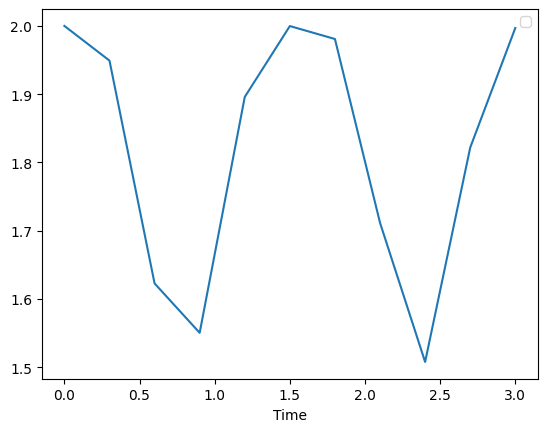

In [101]:
plt.figure(facecolor='white')
# labels = [r'$p_{100}$', r'$p_{010}$', r'$p_{001}$']
# for i, p_site in enumerate(p_sites):
plt.plot(t_eval, p_sites)
plt.xlabel(r'Time')
# plt.ylabel(r'real E')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


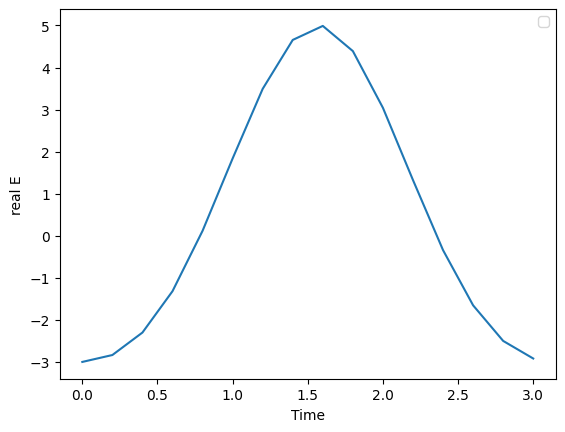

In [57]:
plt.figure(facecolor='white')
# labels = [r'$p_{100}$', r'$p_{010}$', r'$p_{001}$']
# for i, p_site in enumerate(p_sites):
plt.plot(t_eval, p_sites)
plt.xlabel(r'Time')
plt.ylabel(r'real E')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


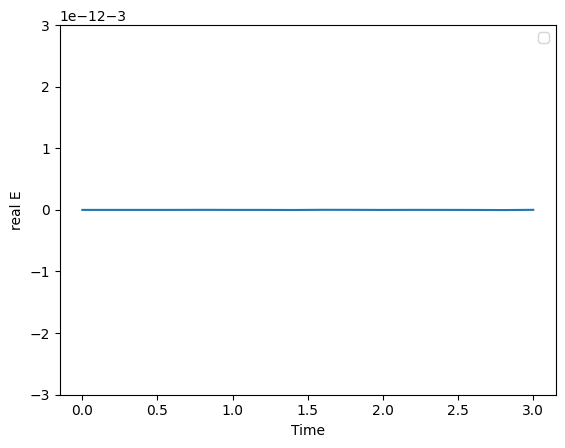

In [53]:
plt.figure(facecolor='white')
# labels = [r'$p_{100}$', r'$p_{010}$', r'$p_{001}$']
# for i, p_site in enumerate(p_sites):
plt.plot(t_eval, p_sites)
plt.xlabel(r'Time')
plt.ylabel(r'real E')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


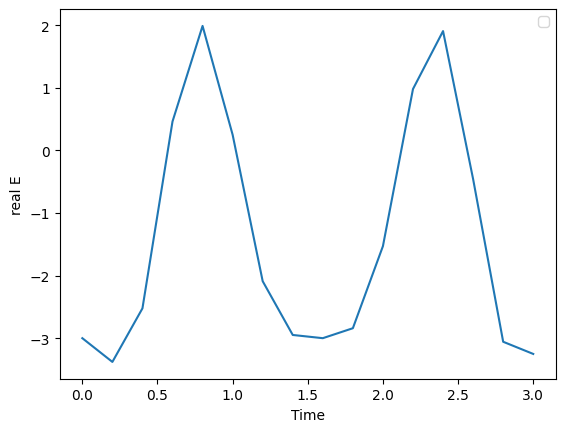

In [48]:
plt.figure(facecolor='white')
# labels = [r'$p_{100}$', r'$p_{010}$', r'$p_{001}$']
# for i, p_site in enumerate(p_sites):
plt.plot(t_eval, p_sites)
plt.xlabel(r'Time')
plt.ylabel(r'real E')
plt.legend()
plt.show()

As anticipated, we see that the electron jumps freely between different sites of the lattice as would be the case in a conducting material.

### Modeling localization
We can also take all $\epsilon_i$ to have different values, i.e., introduce disorder in our tight-binding model. In particular, Anderson localization is a phenomenon which occurs in the case of uniformly sampled $\epsilon_i \in [-W, W]$ for some sufficiently large $W$. In this case, the electrons become localized on one site instead of moving freely through the lattice (as was the case above). Such behavior is characteristic of an insulating material.

Below, we choose $W=3$ and follow our previous steps. (Beware that, for three sites, sampling $\epsilon_i \in [-W, W]$ might not give a set of $\epsilon_i$ that results in localization since the number of samples is too small. That's why, we use a previously sampled set of $\epsilon_i$ below for whicht localization occurs.)

It becomes evident that the electron remains stuck on site $0$ now.

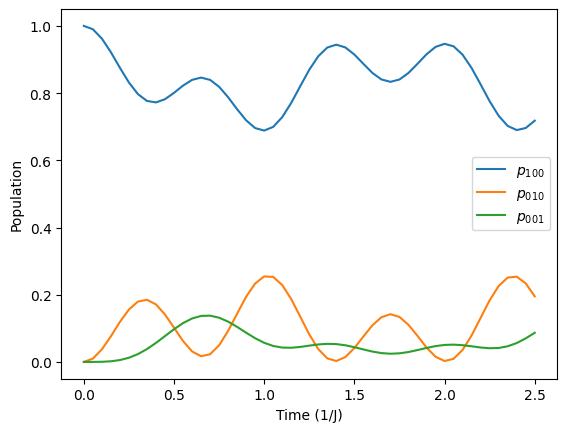

In [5]:
# eps = np.random.uniform(-3, 3, 3)
eps = [-2.48386839, 1.20343038, -0.56565542]

H_tb = H_tightBinding(J, eps)

state_t = [U_t(float(t), H_tb) @ initial_state for t in t_eval]

p_sites = [[np.abs( (~site @ state).eval() )**2 for state in state_t] for site in site_states]

plt.figure(facecolor='white')
labels = [r'$p_{100}$', r'$p_{010}$', r'$p_{001}$']
for i, p_site in enumerate(p_sites):
    plt.plot(t_eval, p_site, label=labels[i])
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
plt.show()

## 2. Trotterization

Now we want to employ one of our quantum algorithms to simulate that same system. In summary, using product formulas:

- decompose $U_{\text{tb}}(t)$ into a product of 1- and 2-qubit gates
- **Product formulas!** Trotter order 1, simplest method
- 3-spin system = sum of two (neighboring) 2-spin subsystems, with $i,j \in \{0,1,2\}$

$$H^{(i,j)}_{\text{tb}} = J( X_i X_j + Y_i Y_j) \ , \ H^z_{\text{tb}} = \sum_i \epsilon_i Z_i
\quad \longrightarrow \quad
U_{\text{tb}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} + H^z_{\text{tb}} \right)\right]$$

- $H^{(0,1)}_{\text{tb}}$, $H^{(1,2)}_{\text{tb}}$, and $H^z_{\text{tb}}$ do **not** commute

$$
U_{\text{tb}}(t) \approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right) \exp\left(\dfrac{-it}{n}H^z_{\text{tb}}\right)\right]^n
$$

- these are the **only non-commuting** terms, terms within $H^{(0,1)}_{\text{tb}}$, etc. commute, e.g., $[AA,BB]=0$ for $A,B \in \{ X,Y,Z \}$
- can exactly factorize

$$
\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) = \exp\left(\dfrac{-it}{n} J X_0 X_1 \right) \exp\left(\dfrac{-it}{n} J Y_0 Y_1 \right)
$$

### Implement Trotterization

To implement product formulas, we use Qiskit's `PauliEvolutionGate` which accepts an argument `synthesis` specifying the kind of product formula we wish to implement. Here, we use `synthesi = LieTrotter` or `synthesi = SuzukiTrotter`.
The creates a gate implementing the circuit corresponding to the product formula appproximation of $e^{-iHt}$ which we can then append to our quantum circuit.

In [116]:
from qiskit.opflow.evolutions import QDrift as qd

In [146]:

H_tb = H_tightBinding(J, eps)

In [145]:
qd(reps=2).convert(H_tb).to_circuit()

In [5]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

num_qubits = 3
circ = QuantumCircuit(num_qubits)
t = Parameter('t')

pf1_gate = PauliEvolutionGate(H_tb, time=t, synthesis=LieTrotter(reps=1))

circ.append(pf1_gate, range(num_qubits))
print(circ.draw())
trans_circ = transpile(circ, backend=BasicAer.get_backend('statevector_simulator'),
                           basis_gates=['id','rz','sx','x','cx','h','S'])
print(trans_circ.draw())

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                     ├
«     │                                                                                      │
«q_1: ┤1 exp(-it (ZZI + IZZ + ZIZ + XXI + IXX + XIX + YYI + IYY + YIY + ZII + IZI + IIZ))(t) ├
«     │                                                                                      │
«q_2: ┤2                                                                                     ├
«     └──────────────────────────────────────────────────────────────────────────────────────┘
global phase: 0
                                                                          ┌───┐»
q_0: ─────────────────────────■─────────────────■────■─────────────────■──┤ H ├»
                            ┌─┴─┐┌───────────┐┌─┴─┐  │      ┌───┐      │  └───┘»
q_1: ──■─────────────────■─

### Simulation using product formulas

We simulate the disordered tight-binding model first with an order one product formula (`LieTrotter`), defining a time interval and number of time steps as above and an initial state (which we take to be the above, but converted to a statevector).
Below, we plot the results.

Importantly, we carry out the Trotter simulation by simply appending one layer of the Trotter circuit at each time step such that at time $t_n$, the circuit consists of $n$ layers of the Trotter circuit.

At each time step, we also count the number of CNOT gates in the circuit to have a measure of computational cost for the implementation. This is done by transpiling the above instruction returned by `PauliEvolutionGate` into a set of basis gates.

In [4]:
c=QuantumCircuit(2)
c.x(1)
c.x(0)
a = qi.Operator(c).data

In [153]:
c=QuantumCircuit(3)
c.h(2)
c.h(0)
c.h(1)
np.matmul(qi.Operator(c).data, np.array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]))

array([0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j,
       0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j, 0.35355339+0.j])

In [7]:
t_target = 3
steps = 10
t_eval = np.linspace(0, t_target, steps + 1)

# c=QuantumCircuit(4)
# c.x(1)
# c.x(0)
# a = qi.Operator(c).data
initial_statevec = np.array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])
# initial_statevec = np.array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])
psi_pf1 = []
# gate_count_pf1 = []
for n in range(0,steps + 1):
    pf_circ = QuantumCircuit(3,3)
    # pf_circ.h(0)
    # pf_circ.h(1)
    # pf_circ.h(2)
    pf_circ.x(0)
    pf_circ.x(2)
    pf1_gate = PauliEvolutionGate(H_tb, time=t_eval[n], synthesis=LieTrotter(reps=n))
    # print(pf1_gate)
    # pf_circ = pf_circ.compose(qd(reps=n).convert(H_tb).to_circuit(),[0,1,2,3])
    pf_circ.append(pf1_gate, range(3))
    # print(pf_circ)
    # trans_circ = transpile(pf_circ, backend=BasicAer.get_backend('statevector_simulator'),
                        #    basis_gates=['id','rz','sx','x','cx','h'])
    # print(trans_circ.draw())
    # gate_count_pf1.append(trans_circ.num_nonlocal_gates())

    evo_mat = qi.Operator(pf_circ).data
    # print(evo_mat.dot(initial_statevec))
    statevec = evo_mat.dot(initial_statevec)
    # if n == 20 :
    #     print(statevec)
    psi_pf1.append(np.conj(statevec).dot(H_tb.to_matrix().dot(statevec)))
    # psi_pf1.append((np.conj(initial_statevec).dot(evo_mat.dot(initial_statevec))))

In [9]:
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ, transpile
Q = QasmSimulator()
simulator = Aer.get_backend("qasm_simulator")
steps = 10
t_eval = np.linspace(0, t_target, steps + 1)
initial_statevec = np.array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])
c = []
def circ(n):
    c = QuantumCircuit(3)
    c.x(0)
    c.x(2)
    c.append(PauliEvolutionGate(H_tb, time=t_eval[n], synthesis=LieTrotter(reps=n)), range(3))
    c.measure_all()
    return c
for n in range(0,steps + 1):
    job = execute(circ(n), backend=simulator, shots=2**15)
    result = job.result()
    counts = result.get_counts()
    c.append(counts)
    print(counts)

{'101': 32768}
{'000': 788, '110': 7943, '101': 16080, '011': 7957}
{'000': 1803, '011': 13099, '101': 4616, '110': 13250}
{'000': 1201, '011': 5261, '110': 5216, '101': 21090}
{'000': 71, '110': 462, '011': 417, '101': 31818}
{'101': 11368, '110': 10368, '000': 496, '011': 10536}
{'000': 1687, '101': 6450, '011': 12310, '110': 12321}
{'000': 1482, '110': 3121, '011': 3017, '101': 25148}
{'000': 209, '110': 1637, '011': 1593, '101': 29329}
{'000': 259, '101': 7368, '110': 12453, '011': 12688}
{'000': 1488, '011': 10792, '110': 10752, '101': 9736}


In [42]:
def count_parity(dict):
    parity = [i for i in list(dict[0].keys())[0]].count('1')
    ratio = np.zeros((len(dict),))
    ratio[0] = 1
    for i in range(1,len(dict)):
        for j in list(dict[i]):
            if list(j).count('1') == parity:
                ratio[i] += dict[i][j]
        ratio[i] = ratio[i]/sum(list(dict[i].values()))
    return ratio

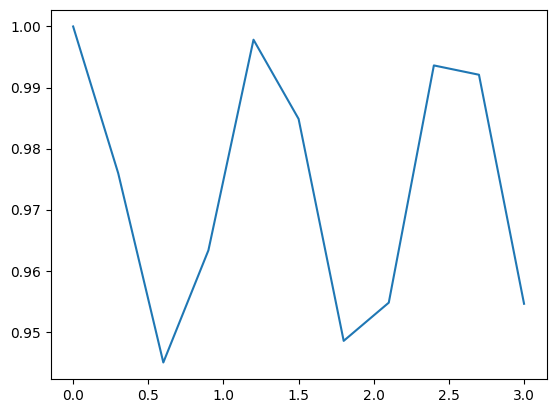

In [44]:
plt.plot(t_eval,count_parity(c))

In [30]:
[i for i in list(c[0].keys())[0]].count('1') * list(c[0].values())[0]

65536

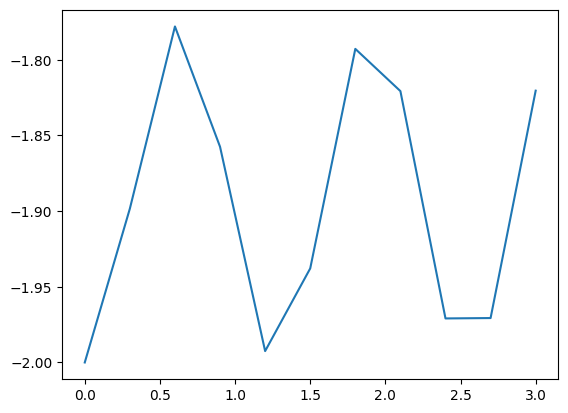

In [23]:
plt.plot(t_eval, psi_pf1)

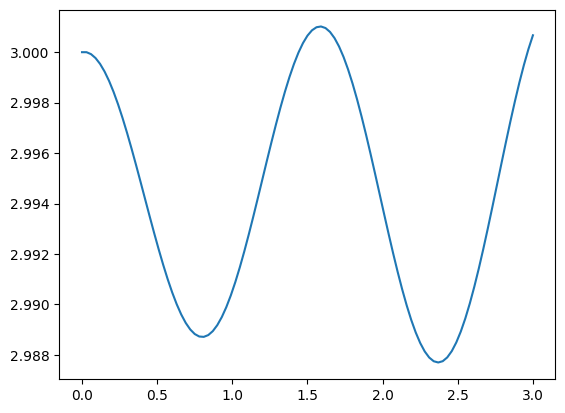

In [93]:
plt.plot(t_eval, psi_pf1)

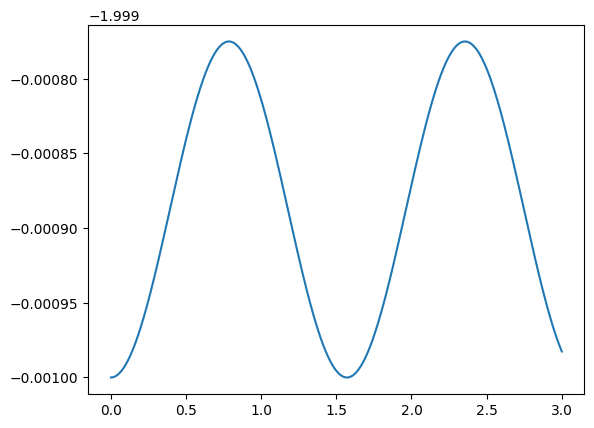

In [89]:
plt.plot(t_eval, psi_pf1)

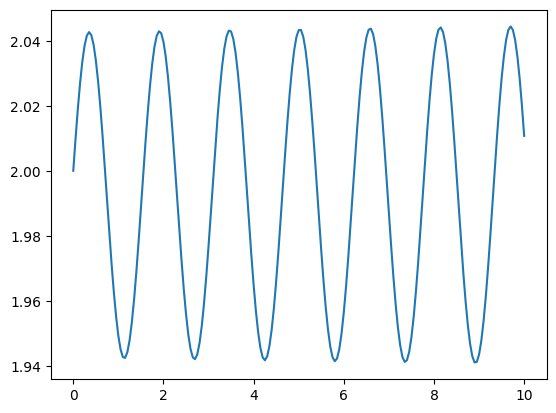

In [164]:
plt.plot(t_eval, psi_pf1)

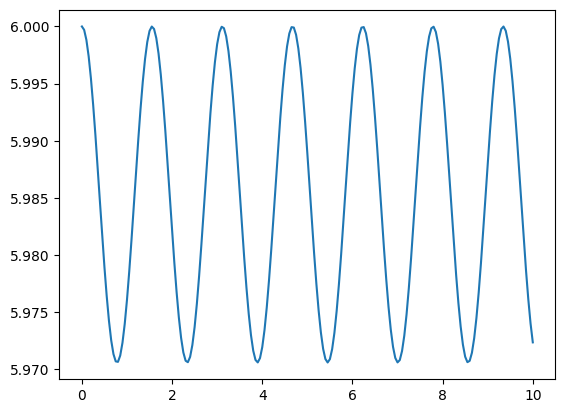

In [162]:
plt.plot(t_eval, psi_pf1)

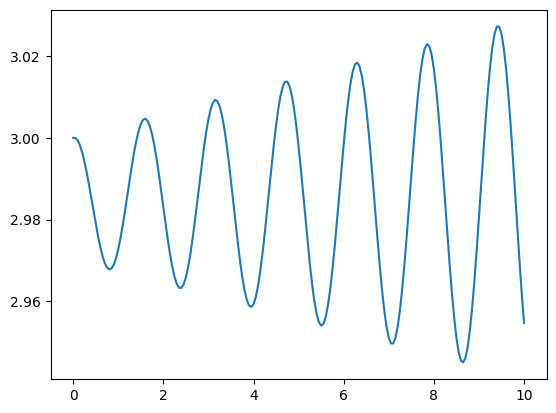

In [160]:
plt.plot(t_eval, psi_pf1)

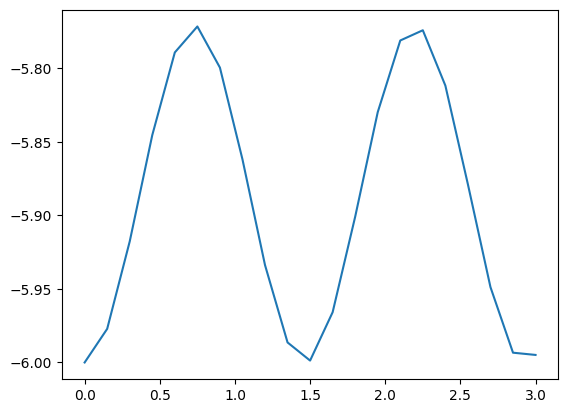

In [49]:
plt.plot(t_eval, psi_pf1)

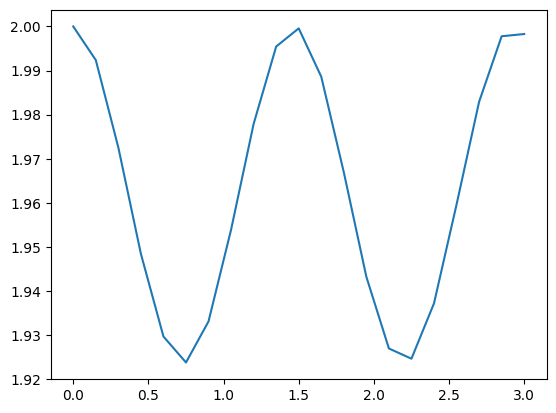

In [43]:
plt.plot(t_eval, psi_pf1)

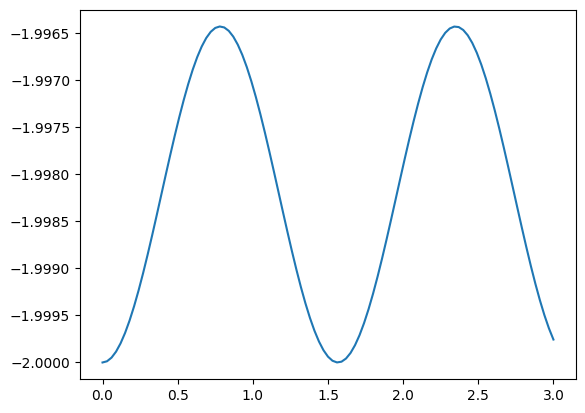

In [26]:
plt.plot(t_eval, psi_pf1)

In [21]:
site_statevecs = [s.to_matrix_op().to_matrix() for s in site_states]

p_sites = [[np.abs(np.conj(site).dot(psi))**2 for psi in psi_pf1] for site in site_statevecs]

plt.figure(facecolor='white')
for i, p_site in enumerate(p_sites):
    plt.plot(t_eval, p_site, label=labels[i])
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
plt.show()

ValueError: shapes (8,) and (16,16) not aligned: 8 (dim 0) != 16 (dim 0)

### Comparison with order-2 product formula

The same can be done for an order two product formula.
Below, we compute the infidelities of both the order one and two simulations as a measure of accuracy (simulation error), i.e., we compute $1- \langle \Psi_\mathrm{exact}(t) | \Psi_\mathrm{trotter}(t) \rangle$ for all time steps.

Plotting the infidelity as well as the number of CNOT gates constituting the circuits at each time step, we see that the order-2 approach gives much better accuracy at the cost of more CNOT gates.

However, we do not compare the two on an equal footing since we merely appended a circuit layer at each time step, thus not leveraging the fact that an order-2 formula is more accurate in the first place.
We can see below that an order-2 formula -- in the case of the tight-binding model -- in fact gives a reduced gate-cost at the same accuracy compared to an order-1 formula.

In [9]:
psi_pf2 = []
gate_count_pf2 = []
for n in range(steps + 1):
    pf_circ = QuantumCircuit(num_qubits)
    
    pf2_gate = PauliEvolutionGate(H_tb, time=t_eval[n], synthesis=SuzukiTrotter(order=2, reps=n))
    pf_circ.append(pf2_gate, range(num_qubits))
    
    trans_circ = transpile(pf_circ, backend=BasicAer.get_backend('statevector_simulator'),
                           basis_gates=['id','rz','sx','x','cx'])
    gate_count_pf2.append(trans_circ.num_nonlocal_gates())
    
    evo_mat = qi.Operator(pf_circ).data
    psi_pf2.append(evo_mat.dot(initial_statevec))

In [10]:
infidelity_pf1 = []
infidelity_pf2 = []
for i in range(len(psi_pf1)):
    infidelity_pf1.append(1 - np.abs(np.conj(state_t[i].eval().to_matrix()).dot(psi_pf1[i]))**2)
    infidelity_pf2.append(1 - np.abs(np.conj(state_t[i].eval().to_matrix()).dot(psi_pf2[i]))**2)

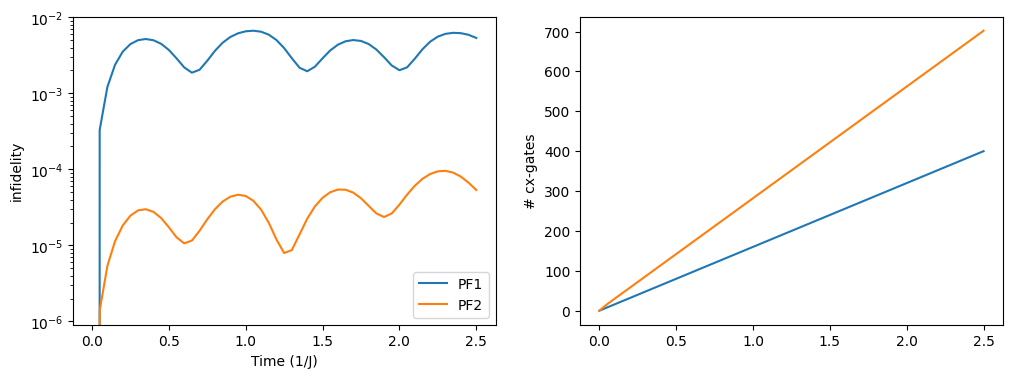

In [11]:
fig, axs = plt.subplots(1, 2, sharex='col', figsize=(2*6, 4))
axs[0].plot(t_eval, infidelity_pf1, label='PF1')
axs[0].plot(t_eval, infidelity_pf2, label='PF2')
axs[1].plot(t_eval, gate_count_pf1, label='PF1')
axs[1].plot(t_eval, gate_count_pf2, label='PF2')
axs[0].set_xlabel(r'Time (1/J)')
axs[0].set_ylabel(r'infidelity')
axs[1].set_ylabel(r'# cx-gates')
axs[0].set_yscale('log')
axs[0].legend()
plt.show()

### Fair comparison with order-2 product formula

To see this, we can instead demand to have a constant accuracy throughout the simulation. For this, we define an error threshold $\epsilon_\mathrm{thresh}$, compute the infidelity at each time step, and append a circuit layer to our Trotter circuit **only** if the infidelity (error) of our simulation increases above this threshold, $\epsilon_\mathrm{trotter} > \epsilon_\mathrm{thresh}$.

We do this for both order-1 and order-1 analogous to the previous simulation and plot the results below.
Now we see that, at a constant simulation error, the order-2 formula requires less CNOT gates than the order-1 formula.

In [ ]:
psi_pf1_thresh = []
gate_count_pf1_thresh = []
infidelity_pf1_thresh = []

thresh = 1e-2
depth = 1
n = 0

while n < steps + 1:
    print(f'step {n}, time {t_eval[n]}')
    pf_circ = QuantumCircuit(num_qubits)
    pf1_gate = PauliEvolutionGate(H_tb, time=t_eval[n], synthesis=LieTrotter(reps=depth))
    pf_circ.append(pf1_gate, range(num_qubits))
    
    evo_mat = qi.Operator(pf_circ).data
    psi_t = evo_mat.dot(initial_statevec)
    infidelity = 1 - np.abs(np.conj(state_t[n].eval().to_matrix()).dot(psi_t))**2
    if infidelity < thresh:
        if n == len(infidelity_pf1_thresh):
            infidelity_pf1_thresh.append(infidelity)
            psi_pf1_thresh.append(psi_t)
            
            trans_circ = transpile(pf_circ, backend=BasicAer.get_backend('statevector_simulator'),
                                   basis_gates=['id','rz','sx','x','cx'])
            gate_count_pf1_thresh.append(trans_circ.num_nonlocal_gates())
        n += 1
    else:
        depth += 1
        print(f" *** infidelity: {infidelity} --> increased depth: {depth}")

In [ ]:
psi_pf2_thresh = []
gate_count_pf2_thresh = []
infidelity_pf2_thresh = []

thresh = 1e-2
depth = 1
n = 0

while n < steps + 1:
    print(f'step {n}, time {t_eval[n]}')
    pf_circ = QuantumCircuit(num_qubits)
    pf2_gate = PauliEvolutionGate(H_tb, time=t_eval[n],
                                  synthesis=SuzukiTrotter(order=2, reps=depth))
    pf_circ.append(pf2_gate, range(num_qubits))
    
    evo_mat = qi.Operator(pf_circ).data
    psi_t = evo_mat.dot(initial_statevec)
    infidelity = 1 - np.abs(np.conj(state_t[n].eval().to_matrix()).dot(psi_t))**2
    if infidelity < thresh:
        if n == len(infidelity_pf2_thresh):
            infidelity_pf2_thresh.append(infidelity)
            psi_pf2_thresh.append(psi_t)
            
            trans_circ = transpile(pf_circ, backend=BasicAer.get_backend('statevector_simulator'),
                           basis_gates=['id','rz','sx','x','cx'])
            gate_count_pf2_thresh.append(trans_circ.num_nonlocal_gates())
        n += 1
    else:
        depth += 1
        print(f" *** infidelity: {infidelity} --> increased depth: {depth}")

In [ ]:
fig, axs = plt.subplots(1, 2, sharex='col', figsize=(2*6, 4))
axs[0].plot(t_eval, infidelity_pf1_thresh, label='PF1')
axs[0].plot(t_eval, infidelity_pf2_thresh, label='PF2')
axs[1].plot(t_eval, gate_count_pf1_thresh, label='PF1')
axs[1].plot(t_eval, gate_count_pf2_thresh, label='PF2')
axs[0].set_xlabel(r'Time (1/J)')
axs[0].set_ylabel(r'infidelity')
axs[1].set_ylabel(r'# cx-gates')
axs[0].set_yscale('log')
axs[0].legend()
plt.show()